In [10]:
import gc
import sys
sys.path.append("/home/cyprien/Documents/github/pytorch-forecasting")

import pytorch_lightning as pl
import seaborn as sns
import torch
from data_factory.dataLoader import StockPricesLoader
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import notebook

from utilities import *

from tqdm.notebook import tqdm

%matplotlib inline
sns.set_style("whitegrid")
notebook.tqdm().pandas()

pl.seed_everything(42)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


0it [00:00, ?it/s]

Global seed set to 42


42

In [11]:
config = load_config("../config/config.yml")

assert config['model'] == 'temporal_fusion_transformer', 'Invalid model in file configuration for this script'

dl = StockPricesLoader(use_previous_files=True)
if not dl.initialized:
    dl.init()

INFO:data_factory.dataLoader:Use previously generated file ../data/save//export_8bef09f9335f87bc015fe80b437b15ab.p. 
            Can not redo preprocessing by loading from generated file.


## TemporalFusionTransformer

In [12]:
from pytorch_forecasting.models import TemporalFusionTransformer
import logging
from logging import WARNING
logging.basicConfig(level=WARNING)

early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-4, patience=2, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

args = dict(
    hidden_size=config['temporal_fusion_transformer']['hidden_size'],
    lstm_layers=config['temporal_fusion_transformer']['lstm_layers'],
    dropout=config['temporal_fusion_transformer']['dropout'],
    attention_head_size=config['temporal_fusion_transformer']['attention_head_size'],
    output_size=config['temporal_fusion_transformer']['output_size'],
)

trainer = pl.Trainer(
    accelerator='cpu',
    gradient_clip_val=0.1,
    # clipping gradients is a hyperparameter and important to prevent divergence
    # of the gradient for recurrent neural networks
    auto_lr_find=True,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    weights_summary="top",
)

model = TemporalFusionTransformer.from_dataset(
    dl.df_train_timeseries,
    **args
)


print(f"Number of parameters in network: {model.size() / 1e3:.1f}k")

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1812: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cyprien/anaconda3/envs/pyto

Number of parameters in network: 23.8k


#### Train the model

In [13]:
## fit network

fit = False

if fit:
    trainer.fit(model, train_dataloaders=dl.train_dl, val_dataloaders=None)
else:
    model = TemporalFusionTransformer.load_from_checkpoint('./lightning_logs/lightning_logs/version_41/checkpoints/epoch=0-step=46790.ckpt')


### Results

In [33]:
import numpy as np

# actuals = torch.cat([y for _, (y, _) in tqdm(iter(dl.test_dl))])
# predictions = trainer.predict(model, (X for X, (y, _) in dl.test_dl))

predictions_np = np.array([i.prediction.numpy() for i in predictions]).reshape(-1, dl.max_prediction_length, config['temporal_fusion_transformer']['output_size'])
actuals_np = actuals.cpu().detach().numpy()

predictions_np.shape, actuals_np.shape


((170000, 10, 7), (170000, 10))

In [39]:
actuals_unscaled = actuals_np.reshape(dl.df_train_ppc.SecuritiesCode.unique().size, -1, dl.max_prediction_length).copy()
predictions_unscaled = predictions_np.reshape(dl.df_train_ppc.SecuritiesCode.unique().size, -1, dl.max_prediction_length * 7).copy()

for i, scaler in enumerate(dl.scalers['Close']):
    actuals_unscaled[i] = scaler.inverse_transform(actuals_unscaled[i])
    predictions_unscaled[i] = scaler.inverse_transform(predictions_unscaled[i])

actuals_unscaled = actuals_unscaled.reshape(-1, 10)
predictions_unscaled = predictions_unscaled.reshape(-1, 10, 7)

In [51]:

df_test_res = dl.df_test_ppc.copy()

df_test_res['close_true'] = actuals_np[:, 0].flatten()
df_test_res['close_pred'] = predictions_np[:, 0, 3].flatten()

df_test_res['close_true_unscaled'] = actuals_unscaled[:, 0].flatten()
df_test_res['close_pred_unscaled'] = predictions_unscaled[:, 0, 3].flatten()

df_test_res['target_true'] = (actuals_np[:, 1] - actuals_np[:, 0]) / actuals_np[:, 0]
df_test_res['target_pred'] = (predictions_np[:, 1, 3] - predictions_np[:, 0, 3]) / predictions_np[:, 0, 3]

# df_test_res['close_true_unscaled_full'] = pd.Series(list(actuals_unscaled[:, :]))
df_test_res['close_pred_unscaled_full_0'] = pd.Series(list(predictions_unscaled[:, :, 0]))
df_test_res['close_pred_unscaled_full_1'] = pd.Series(list(predictions_unscaled[:, :, 1]))
df_test_res['close_pred_unscaled_full_2'] = pd.Series(list(predictions_unscaled[:, :, 3]))
df_test_res['close_pred_unscaled_full_3'] = pd.Series(list(predictions_unscaled[:, :, 5]))
df_test_res['close_pred_unscaled_full_4'] = pd.Series(list(predictions_unscaled[:, :, 6]))

df_test_res['target_true_unscaled'] = (actuals_unscaled[:, 1] - actuals_unscaled[:, 0]) / actuals_unscaled[:, 0]
df_test_res['target_pred_unscaled'] = (predictions_unscaled[:, 1, 3] - predictions_unscaled[:, 0, 3]) / predictions_unscaled[:, 0, 3]

df_test_res.loc[:, ['Close', 'close_true_unscaled', 'close_pred_unscaled', 'Target', 'target_true_unscaled', 'target_pred_unscaled']]


/tmp/ipykernel_12649/670285299.py:9: RuntimeWarning: invalid value encountered in true_divide
  df_test_res['target_true'] = (actuals_np[:, 1] - actuals_np[:, 0]) / actuals_np[:, 0]


,Close,close_true_unscaled,close_pred_unscaled,Target,target_true_unscaled,target_pred_unscaled
0,2971.0,3065.000000,2940.569336,-0.003263,-0.003263,-0.001627
1,3065.0,3055.000000,3058.050049,0.009820,0.009820,-0.005015
2,3055.0,3085.000000,3046.288330,0.006483,0.006483,-0.003457
3,3085.0,3105.000000,3078.006592,-0.006441,0.000000,0.000135
4,3105.0,3105.000000,3104.996582,-0.008104,0.000000,0.000450
...,...,...,...,...,...,...
169995,719.0,733.000000,740.015076,0.001364,0.000000,-0.001479
169996,733.0,733.000000,746.205688,-0.001362,0.000000,-0.002117
169997,733.0,733.000000,746.451355,-0.001362,0.001364,0.002296
169998,733.0,734.000000,749.471985,-0.001362,0.345674,0.291920


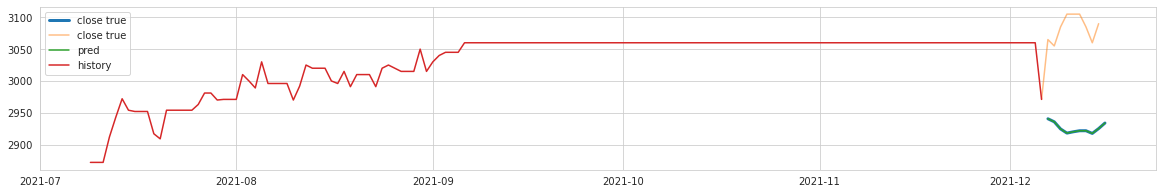

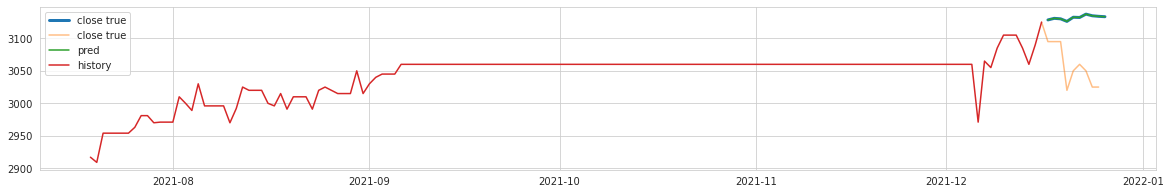

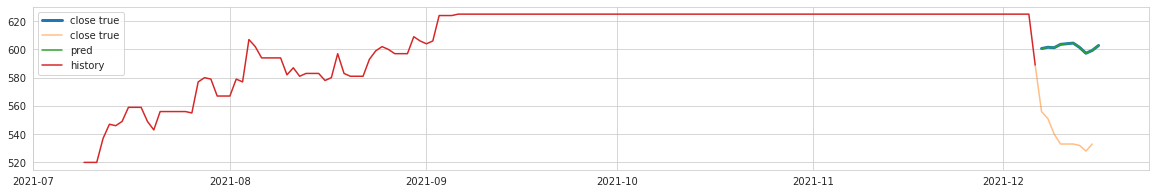

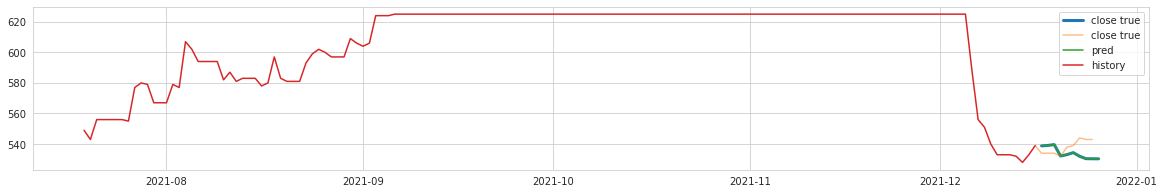

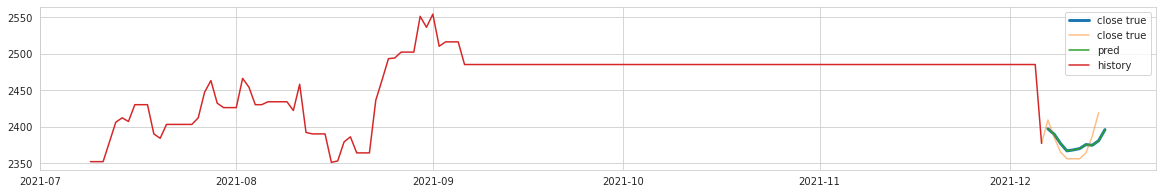

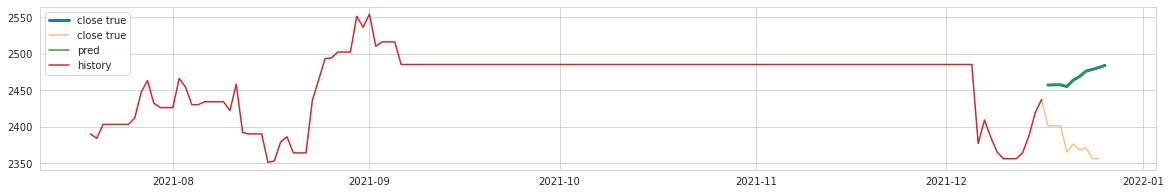

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

for sc in df_test_res.SecuritiesCode.unique()[:3]:
    for start_point in [0, 10]:

        df = df_test_res[(df_test_res.SecuritiesCode == sc)]
        df = df[(df.Timestamp >= df.Timestamp.min() + start_point) & (df.Timestamp < df.Timestamp.min() + start_point + dl.max_prediction_length)]
        df_full = dl.df_test_ppc_ext[(dl.df_test_ppc_ext.SecuritiesCode == sc)]
        df_full = df_full[(df_full.Timestamp >= df.Timestamp.min() - dl.max_encoder_length) & (df_full.Timestamp <= df.Timestamp.min())]

        figure = plt.figure(figsize=(20, 3))

        plt.plot(df.Date + pd.Timedelta(days=1), df.close_pred_unscaled_full_2.iloc[0], label='close true', figure=figure, linewidth=3)
        plt.plot(df.Date, df.Close, label='close true', figure=figure, alpha=.5)


        plt.plot(df.Date + pd.Timedelta(days=1), df.close_pred_unscaled_full_2.iloc[0], label='pred', figure=figure)
        plt.plot(df_full.Date, df_full.Close, label='history', figure=figure)

        plt.legend()
        plt.show()

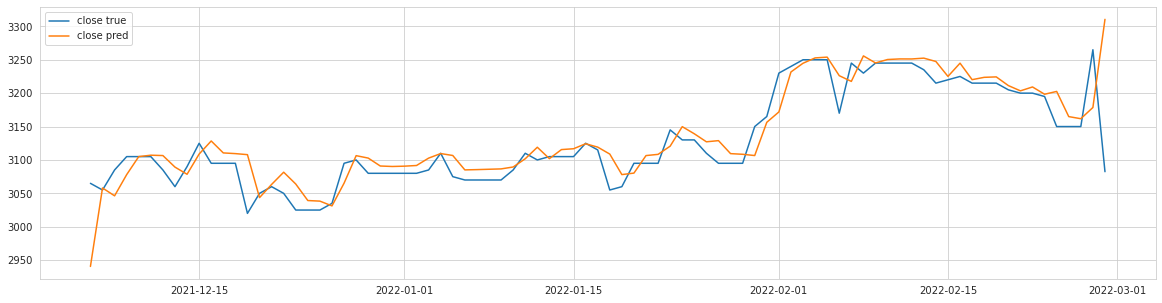

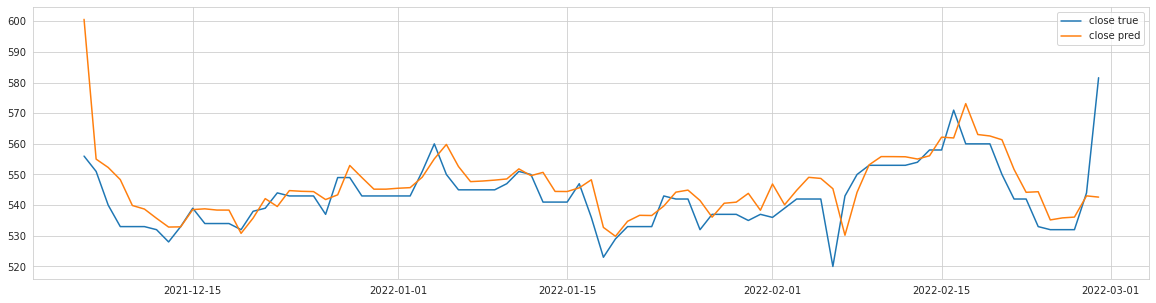

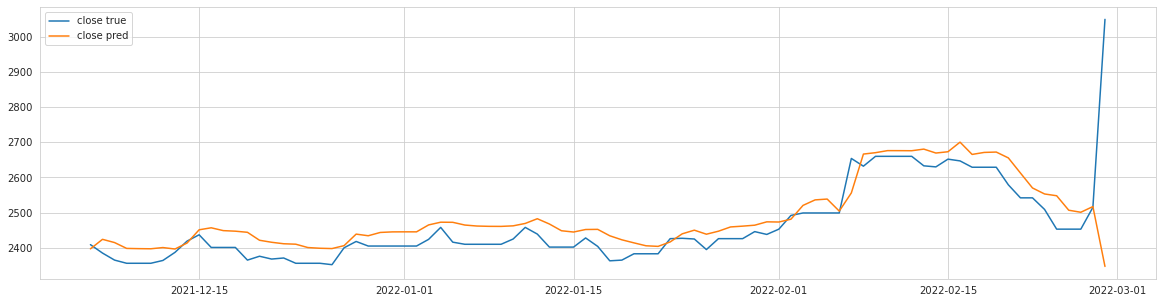

In [45]:
import matplotlib.pyplot as plt

for sc in dl.df_train_ppc.SecuritiesCode.unique()[:3]:
    df = df_test_res[df_test_res.SecuritiesCode == sc]
    figure = plt.figure(figsize=(20, 5))
    # plt.plot(df.Date, df.Close, label='close true', figure=figure)
    plt.plot(df.Date, df.close_true_unscaled, label='close true', figure=figure)
    plt.plot(df.Date, df.close_pred_unscaled, label='close pred', figure=figure)

    plt.legend()
    plt.show()

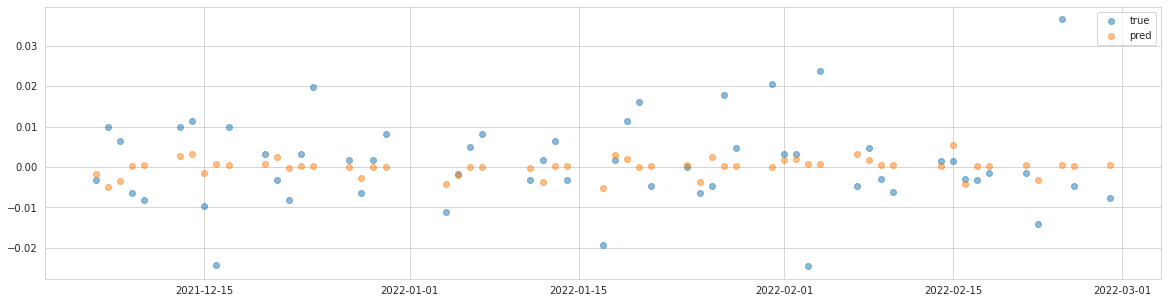

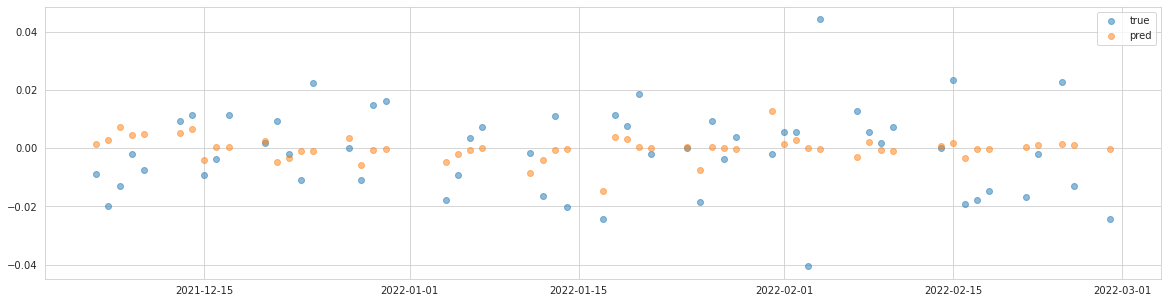

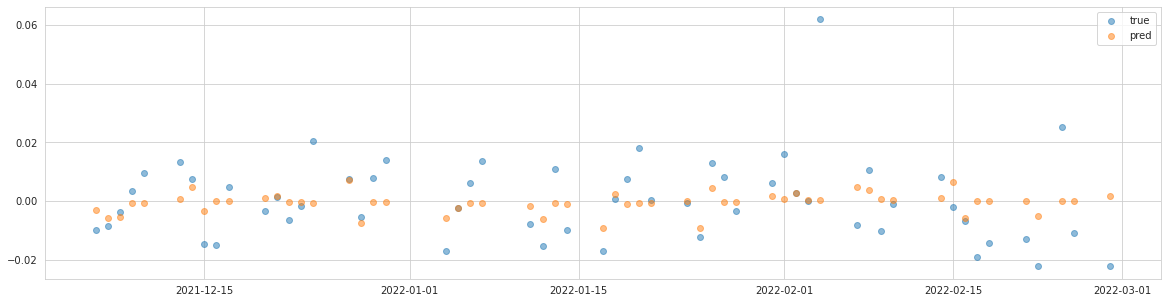

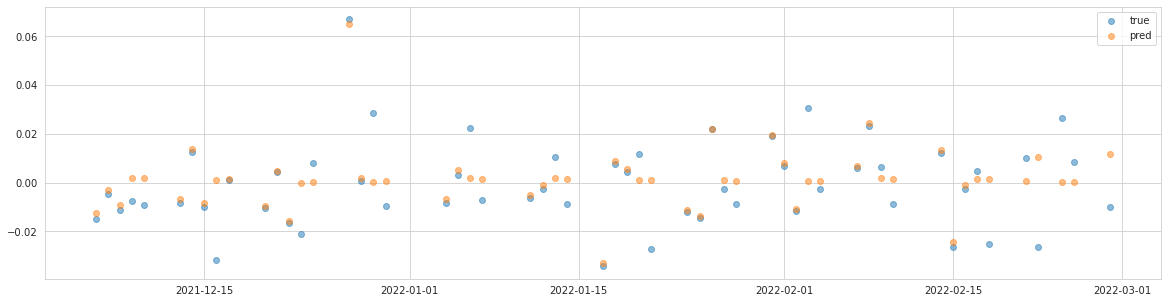

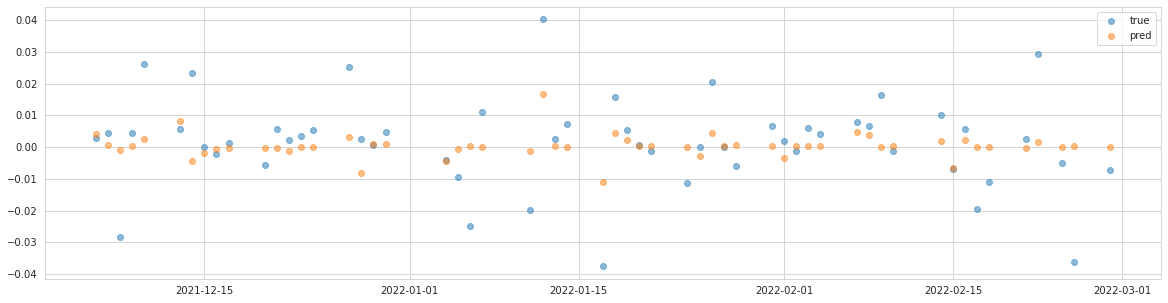

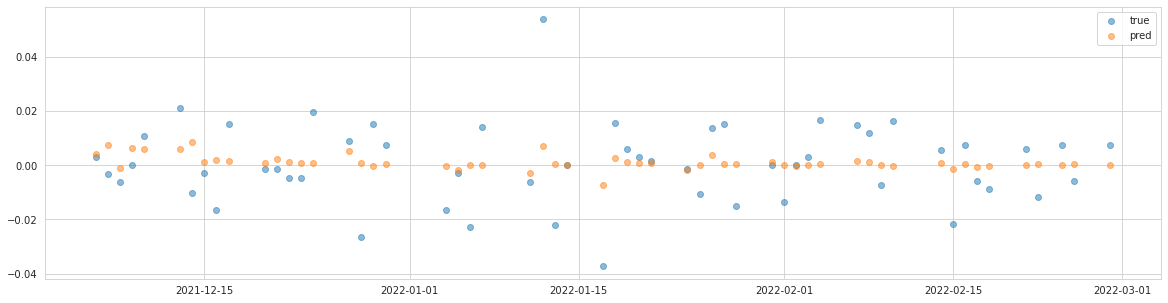

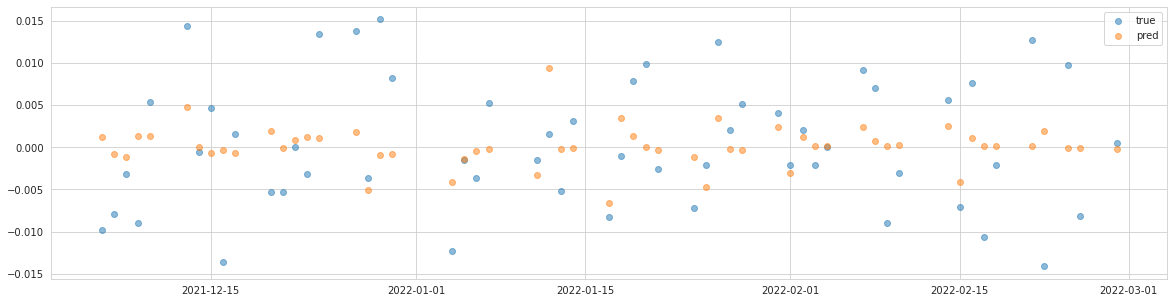

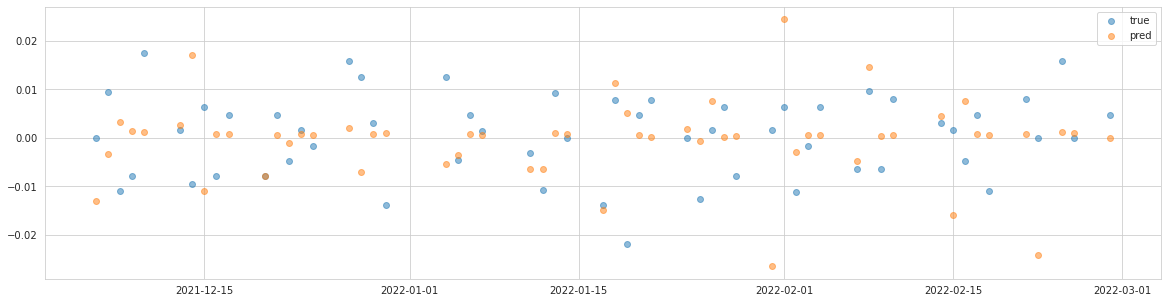

In [46]:
import matplotlib.pyplot as plt

recreated_target_is_valid = df_test_res.groupby('SecuritiesCode').apply(lambda x: (x.authentic == True).shift(-2).fillna(value=False) & (x.authentic == True).shift(-1).fillna(value=False) & (x.authentic == True)).reset_index(drop=True)
evaluated_target = (df_test_res.authentic == True)

for sc in df_test_res.SecuritiesCode.unique()[:8]:
    df = df_test_res[(df_test_res.SecuritiesCode == sc) & evaluated_target]
    figure = plt.figure(figsize=(20, 5))
    plt.scatter(df.Date, df.Target, label='true', figure=figure, alpha=.5)
    # plt.scatter(df.Date, df.target_true_unscaled, label='true2', figure=figure, alpha=.5)
    plt.scatter(df.Date, df.target_pred_unscaled, label='pred', figure=figure, alpha=.5)
    plt.legend()
    plt.show()

In [58]:
from utilities.evaluation import calc_spread_return_sharpe

In [59]:
df_test_res['Rank'] = (df_test_res.groupby("Date")["target_true_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
calc_spread_return_sharpe(df_test_res)

0.9333833607342156

In [60]:
df_test_res['Rank'] = (df_test_res.groupby("Date")["target_pred_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
calc_spread_return_sharpe(df_test_res)

0.7957255489305288